# **Lab 2: Brain Tumor MRI Feature Extraction**

- Reece Iriye: 48255107
- Eileen Garcia: 48241821
- Trevor Dohm: 48376059

## **0: Imports**

In [50]:
# Import Statements

# Data Manipulation
import numpy as np
import pandas as pd
import glob
import os

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Image Manipulation
from PIL import Image, ImageEnhance
import cv2

# Machine Learning
import torch
from torch import Tensor
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import (
    DataLoader, 
    TensorDataset, 
    random_split,
    Dataset,
)

# Warnings
from typing import List, Dict, Tuple
import warnings
warnings.filterwarnings('ignore')

## **1: Business & Data Understanding**

## **2: Data Preparation**

In [2]:
# Load Train / Test Data
train_data_mri: str = 'Dataset/Training/'
test_data_mri: str = 'Dataset/Testing/'
IMG_SIZE: int = 256

# Label Encoding
labels: List[str] = ['glioma', 'meningioma', 'notumor', 'pituitary']
label_indexes: Dict[str, int] = {
    label: i 
    for i, label in enumerate(labels)
}

# Empty Lists For Data
train_paths: List[np.ndarray] = []  # List of numpy arrays
train_labels: List[int] = []  # List of integers (encoded labels)
test_paths: List[np.ndarray] = []
test_labels: List[int] = []

# Load Training Data
for label in labels:
    for img_file in glob.glob(train_data_mri + f'/{label}/*.jpg'):
        img: np.ndarray = cv2.imread(img_file, 0)  # This loads in grayscale. Remove ',0' for color.
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize if necessary
        img = img.astype(np.float32) / 255.0  # Normalize pixel values
        train_paths.append(img)
        train_labels.append(label_indexes[label])

# Load Testing Data
for label in labels:
    for img_file in glob.glob(test_data_mri + f'/{label}/*.jpg'):
        img: np.ndarray = cv2.imread(img_file, 0)  # This loads in grayscale. Remove ',0' for color.
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize if necessary
        img = img.astype(np.float32) / 255.0  # Normalize pixel values
        test_paths.append(img)
        test_labels.append(label_indexes[label])  

# Converting Lists To Numpy Arrays
train_paths = np.array(train_paths)
train_labels: np.ndarray = np.array(train_labels)
test_paths: np.ndarray = np.array(test_paths)
test_labels: np.ndarray = np.array(test_labels)

# Resize Data (Linearize Images -> 1D Image Features Table, Row = Image)
train_paths = train_paths.reshape(train_paths.shape[0], -1)
test_paths = test_paths.reshape(test_paths.shape[0], -1)

In [80]:
print(f"Total training data MRI scans: {len(train_paths)}.")
print(f"Total testing data MRI scans:  {len(test_paths) }.")

Total training data MRI scans: 5712
Total testing data MRI scans:  1311


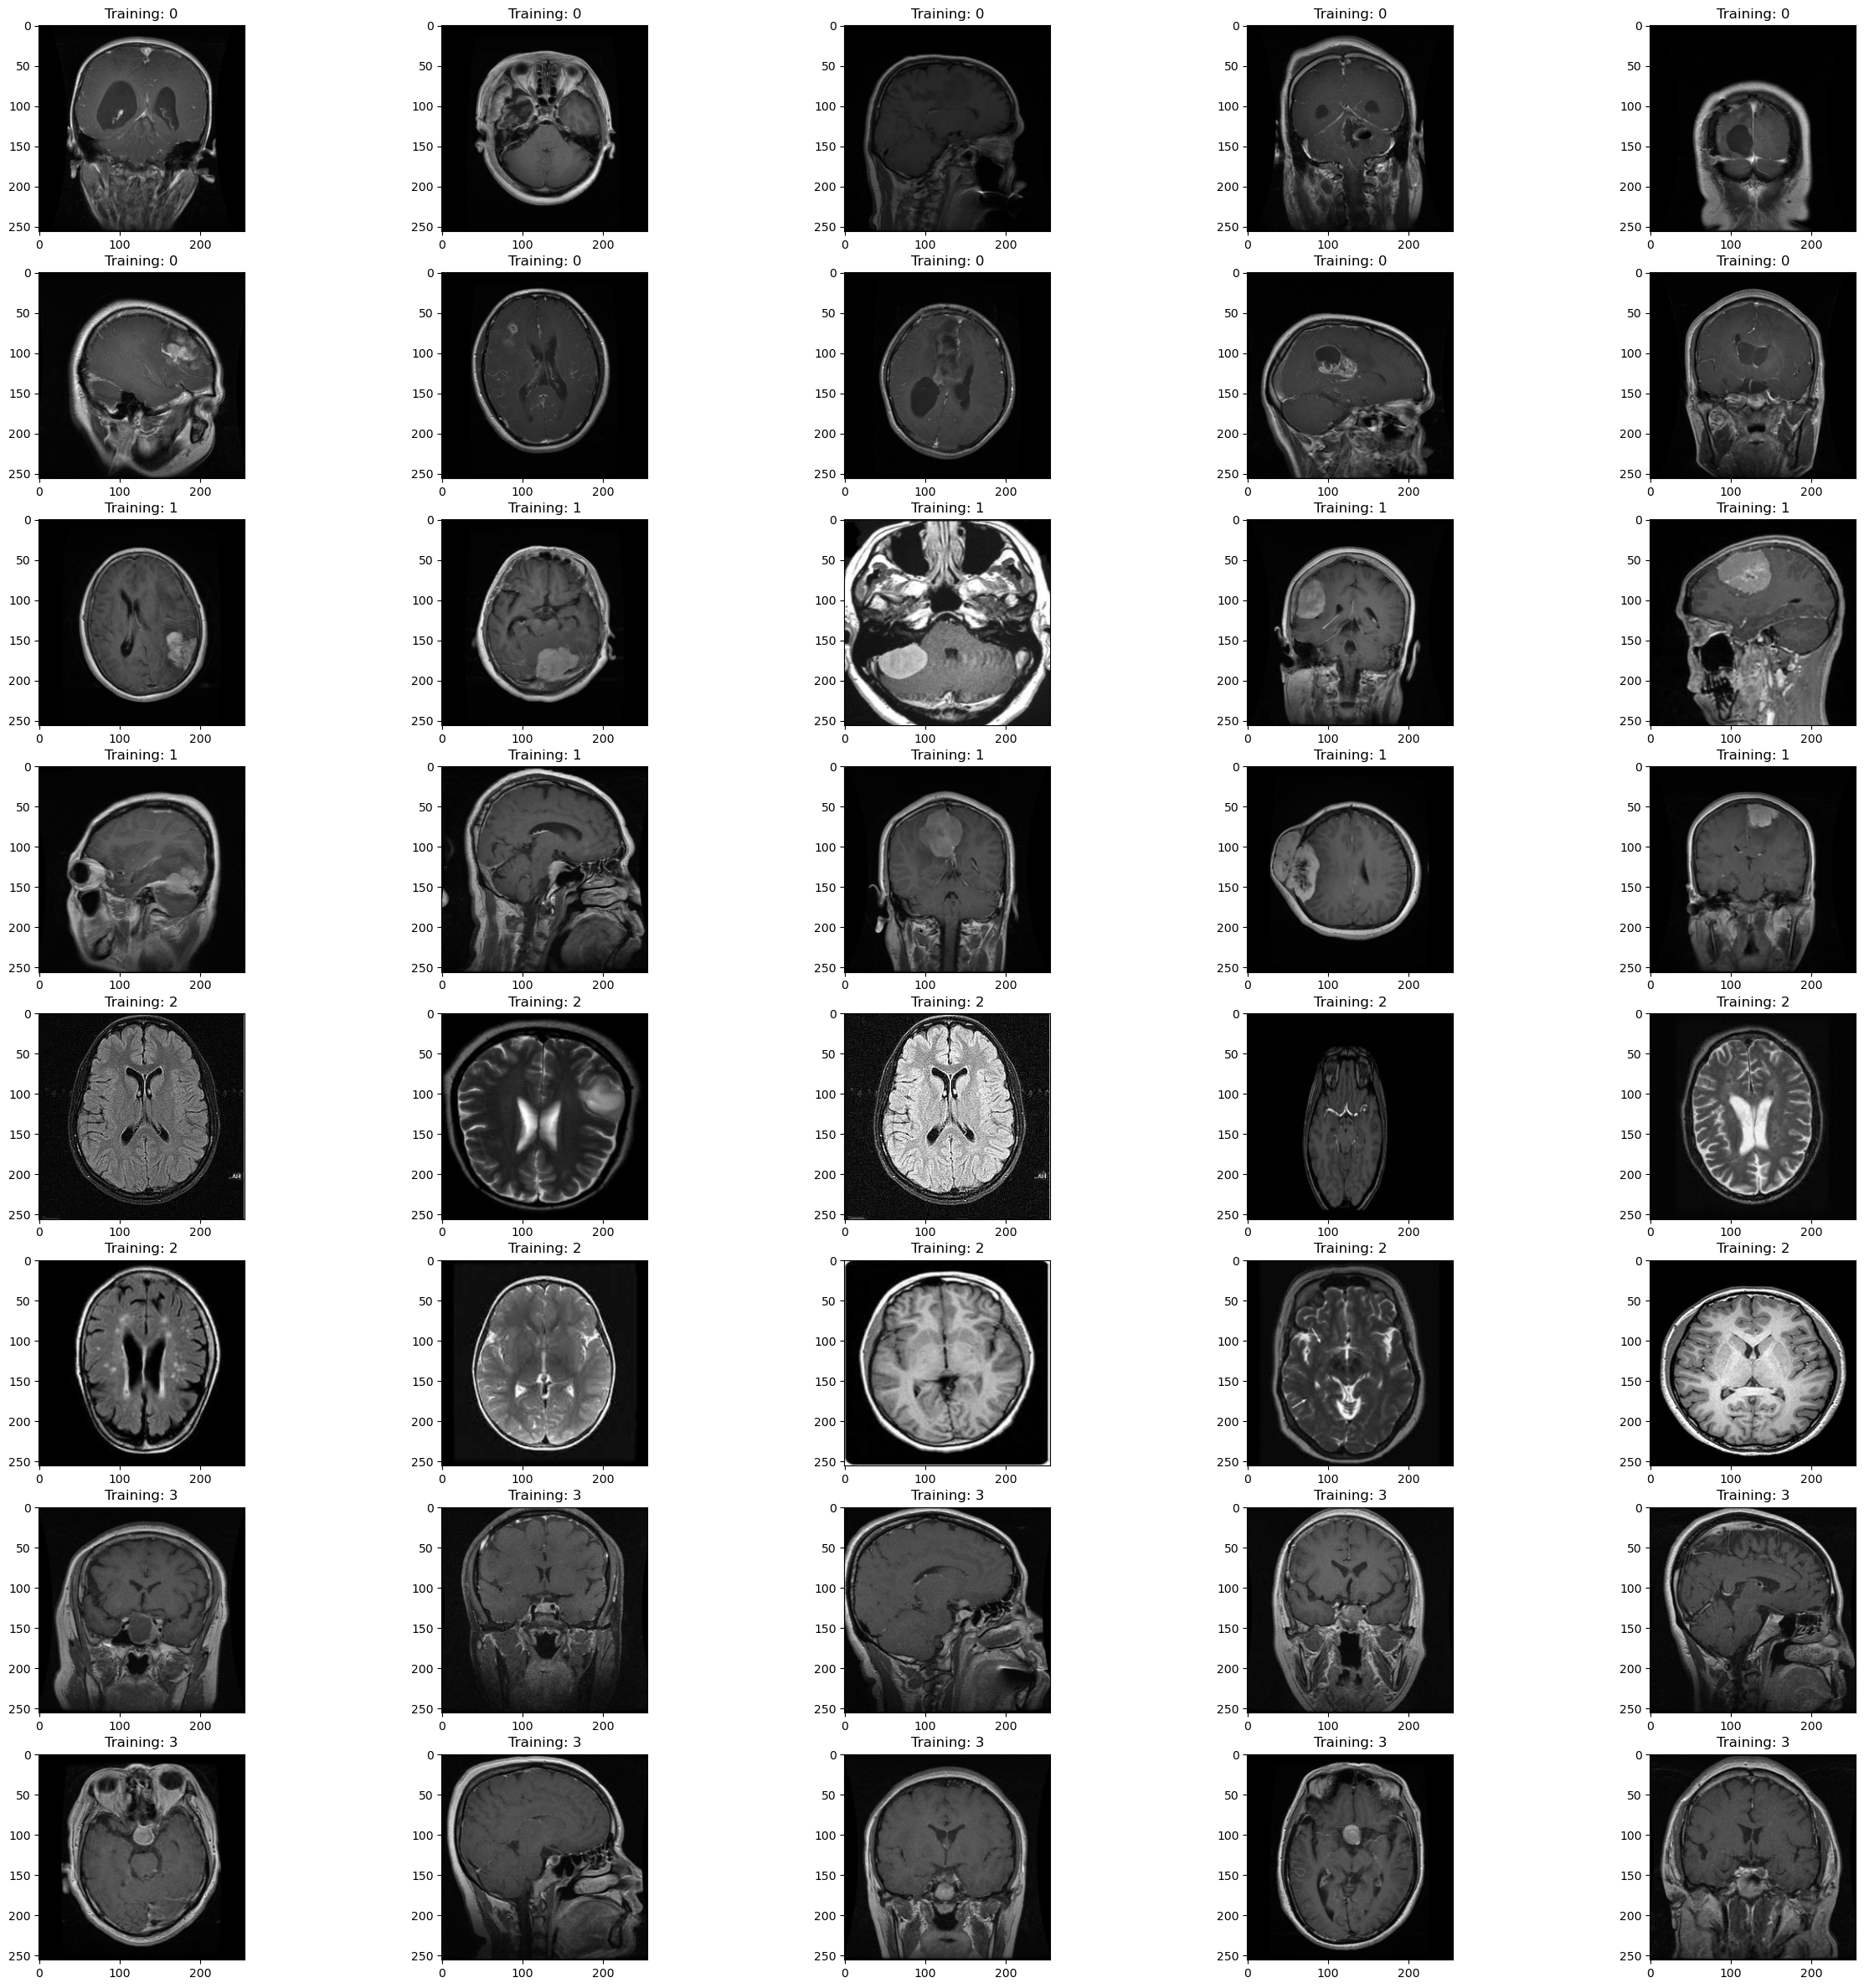

In [78]:
# Display some images from train_paths
plt.figure(figsize=(30, 30))

# Find indices for each label
train_indices_0: List[int] = np.where(np.array(train_labels) == 0)[0]
train_indices_1: List[int] = np.where(np.array(train_labels) == 1)[0]
train_indices_2: List[int] = np.where(np.array(train_labels) == 2)[0]
train_indices_3: List[int] = np.where(np.array(train_labels) == 3)[0]

# Randomly select 10 indices from each set
train_random_indices_0: List[int] = np.random.choice(train_indices_0, 10, replace=False)
train_random_indices_1: List[int] = np.random.choice(train_indices_1, 10, replace=False)
train_random_indices_2: List[int] = np.random.choice(train_indices_2, 10, replace=False)
train_random_indices_3: List[int] = np.random.choice(train_indices_3, 10, replace=False)

train_plot_indices: List[int] = np.concatenate([
    train_random_indices_0, 
    train_random_indices_1, 
    train_random_indices_2, 
    train_random_indices_3,
])

# Ensure indices are unique and within bounds
train_plot_indices = list(set(train_plot_indices))
train_plot_indices.sort()

for index, (image, label) in enumerate(zip(train_paths[train_plot_indices], train_labels[train_plot_indices])):
    plt.subplot(8, 5, index + 1)
    plt.imshow(np.reshape(image, (IMG_SIZE, IMG_SIZE)), cmap=plt.cm.gray)
    plt.title(f'Training: {label}')
    
plt.show()

As we can see above, the images in the Kaggle MRI dataset 

Imaging could be done in a different way or may be showcased as a result of differing proton spins based on how a brain responds to waves being passed into it through an MRI scan. 

<a href="https://www.mr-tip.com/serv1.php?type=db1&dbs=Oblique#:~:text=News%20(%201%20)-,Oblique,axis%20views%20of%20the%20heart.">oblique view</a>

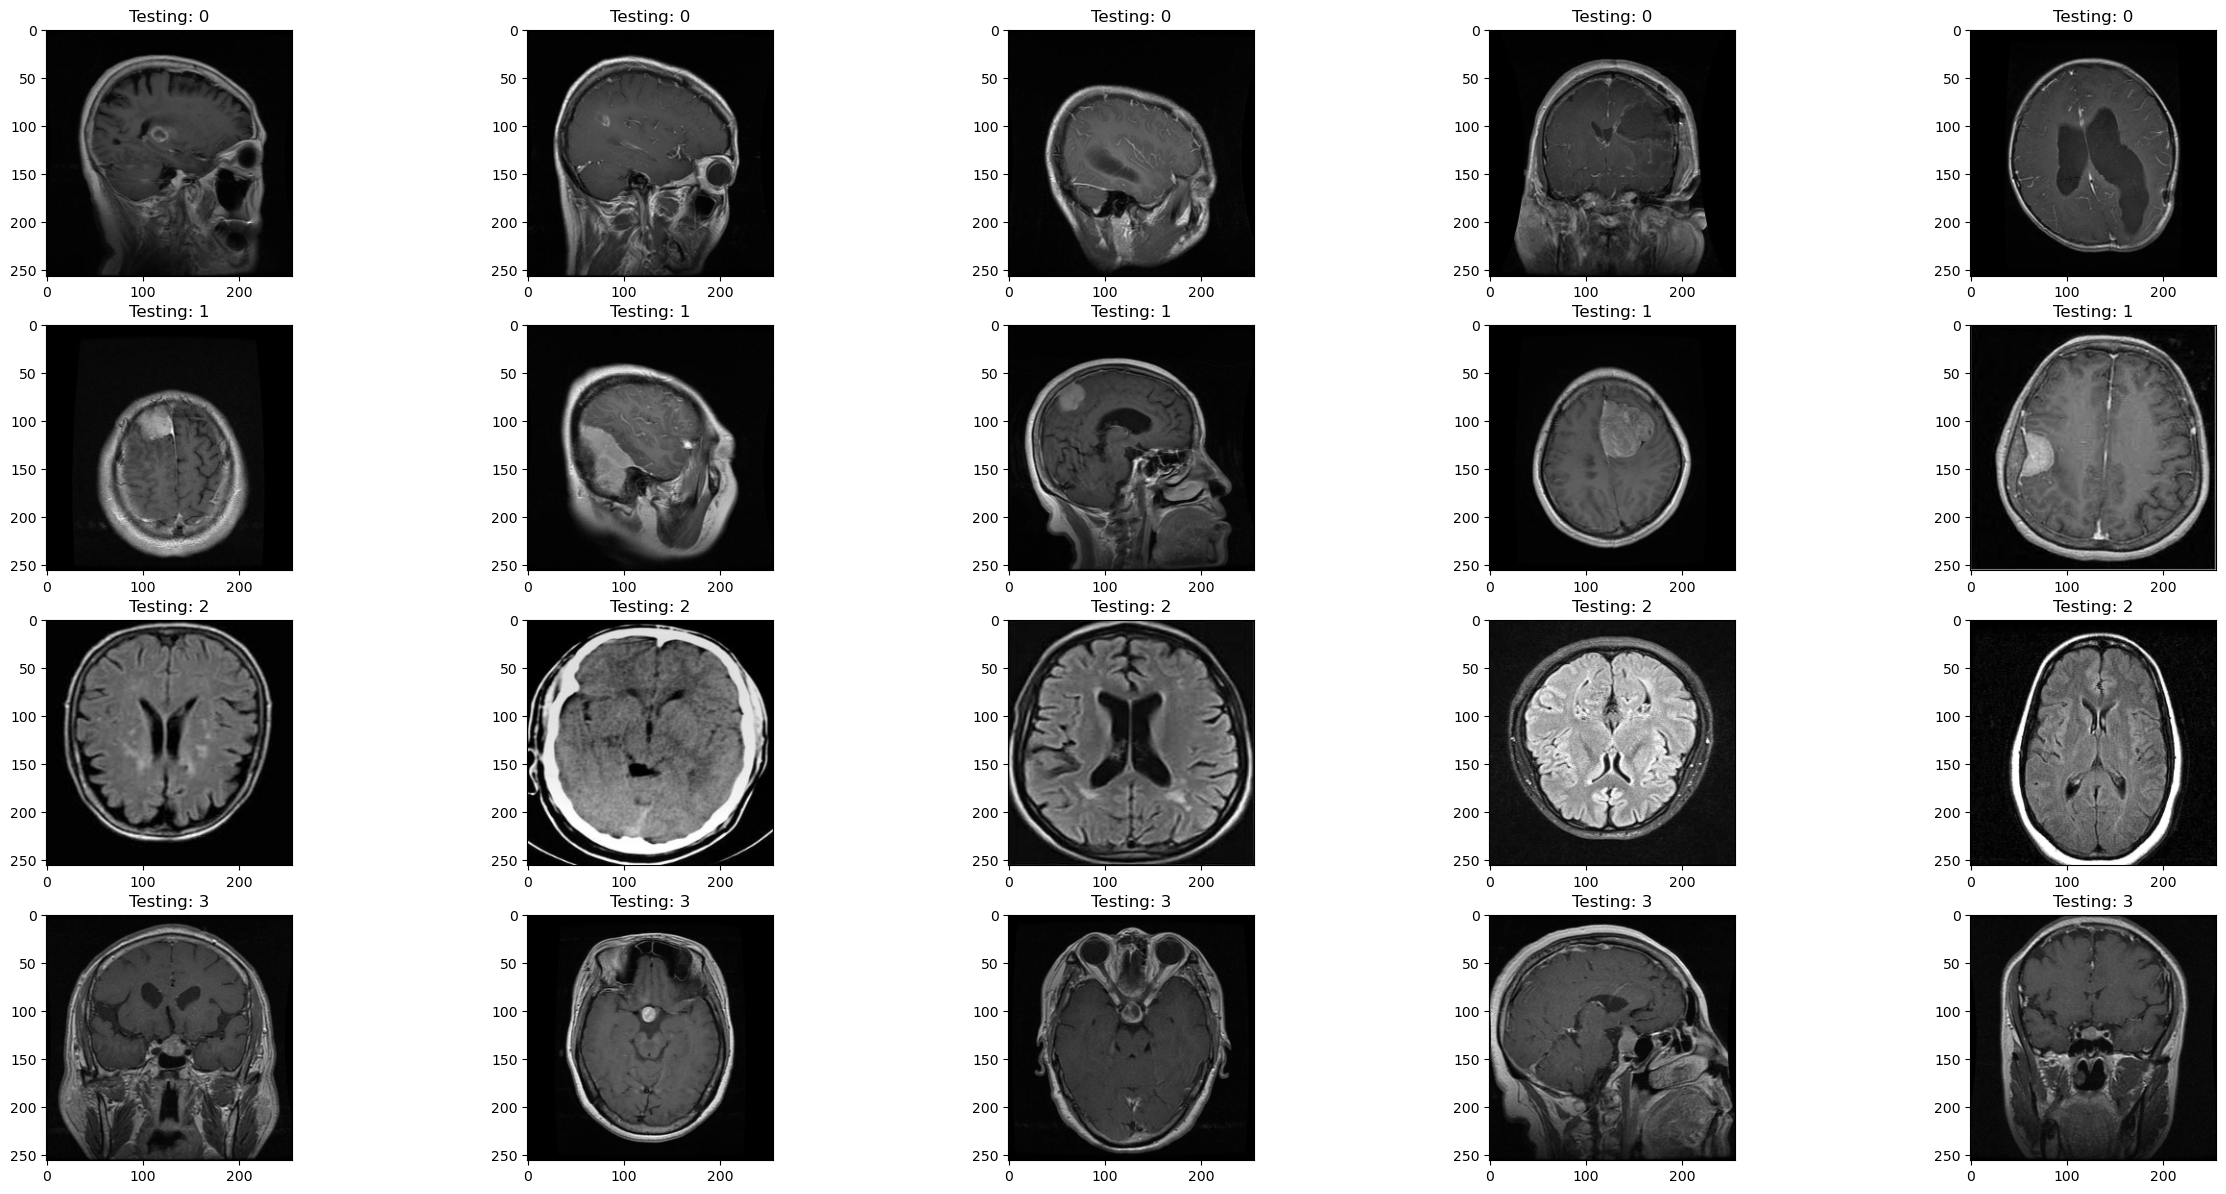

In [82]:
# Display some images from train_paths
plt.figure(figsize=(30, 30))

# Find indices for each label
test_indices_0: List[int] = np.where(np.array(test_labels) == 0)[0]
test_indices_1: List[int] = np.where(np.array(test_labels) == 1)[0]
test_indices_2: List[int] = np.where(np.array(test_labels) == 2)[0]
test_indices_3: List[int] = np.where(np.array(test_labels) == 3)[0]

# Randomly select 5 indices from each set
test_random_indices_0: List[int] = np.random.choice(test_indices_0, 5, replace=False)
test_random_indices_1: List[int] = np.random.choice(test_indices_1, 5, replace=False)
test_random_indices_2: List[int] = np.random.choice(test_indices_2, 5, replace=False)
test_random_indices_3: List[int] = np.random.choice(test_indices_3, 5, replace=False)

test_plot_indices: List[int] = np.concatenate([
    test_random_indices_0, 
    test_random_indices_1, 
    test_random_indices_2, 
    test_random_indices_3,
])

# Ensure indices are unique and within bounds
test_plot_indices = list(set(test_plot_indices))
test_plot_indices.sort()

for index, (image, label) in enumerate(zip(test_paths[test_plot_indices], test_labels[test_plot_indices])):
    plt.subplot(8, 5, index + 1)
    plt.imshow(np.reshape(image, (IMG_SIZE, IMG_SIZE)), cmap=plt.cm.gray)
    plt.title(f'Testing: {label}')
    
plt.show()

## **3: Data Reduction**

### **3.1: Dimensionality Reduction with Principal Component Analysis**

### **3.2: Dimensionality with Randomized Principal Component Analysis**

### **3.3: Compare PCA and Randomized PCA**

### **3.4: Feature Extraction using ResNet & Predictive Analysis**

In [8]:
# Instantiate the ResNet50 model
resnet50: models.ResNet = models.resnet50(pretrained=True)

We decided to use a PyTorch implementation of the <a href="https://www.run.ai/guides/deep-learning-for-computer-vision/pytorch-resnet">Residual Network (ResNet)</a> architecture for prediction. The ResNet architecture was introduced by Kaiming He et al. in their 2016 paper titled "Deep Residual Learning for Image Recognition."

To summarize, ResNet introduced a novel architecture to deal with the vanishing gradient problem that occurs when training very deep neural networks. Other deep neural networks before ResNet faced several challenges that hampered their performance. As these networks became deeper, the gradients, which are crucial for weight updates during training, tended to become <a href="https://www.engati.com/glossary/vanishing-gradient-problem#:~:text=Vanishing%20gradient%20problem%20is%20a,layers%20to%20the%20earlier%20layers.">exceedingly small</a>. This phenomenon, known as the vanishing gradient problem, led to a situation where the weights of neurons, especially in the earlier layers, barely updated. As a result, these layers would learn at a very slow pace, changing negligably or not even at all. These layers, which were often responsible for capturing essential features of input data, are critical for the overall performance of the network. 

To address these challenges, ResNet introduced "residual learning." Central to ResNet are its <a href="https://towardsdatascience.com/resnets-residual-blocks-deep-residual-learning-a231a0ee73d2">residual blocks</a>, which incorporate "skip" or "shortcut" connections. These connections allow input information to bypass one or more layers and directly feed into more relevant layers. This design ensures that even during backpropagation—when a neural network is correcting its parameters when evaluating its performance on the training data at hand—the gradient can flow without significant changes across parameters in the network. By doing so, ResNet alleviates the vanishing gradient problem, enabling the weights in earlier layers to update more effectively. This revitalizes the training dynamics and ensures that deep networks can learn and generalize better without experiencing the vanishing gradient problem like other networks in the past.

ResNet50 specifically has 50 layers and bottleneck building blocks made up of a $1 \times 1$ convolution, a $3 \times 3$ convolution, then another $1 \times 1$ convolution to reduce the number of input and output features once arriving to the $3 \times 3$ convolution. It is known to be a good balance in comparison to other ResNet architectures when it comes to runtime and performance.

#### **3.4.1: Model Performance Evaluation**

In [13]:
%%time
# ChatGPT assisted in the generation of this code block, but it was largely translated into
# a format we found more readable with comments added throughout the code block.

# 1. Prepare the ResNet50 model for transfer learning
# 
# This replaces the last fully connected layer (originally trained for 
# the 1000-class ImageNet dataset) with a new fully connected layer that matches the 
# number of classes in our MRI dataset. Since this layer is newly initialized, it 
# contains random weights and will be trained from scratch, while the other layers 
# contain pre-trained weights from ImageNet.
NUM_CLASSES: int = len(labels)
resnet50.fc: torch.nn.Module = (
    torch.nn.Linear(resnet50.fc.in_features, NUM_CLASSES)
)

# If CUDA (NVIDIA GPU acceleration) is available, use it. Otherwise, use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet50.to(device)  # Send the model to the selected device 

# 2. Prepare datasets for PyTorch
# Convert the loaded MRI images (numpy arrays) to PyTorch tensors
# Convert grayscale images to RGB format by repeating the single channel three times
train_tensors: Tensor = (
    torch.tensor(train_paths)
    .float()
    .view(-1, 1, IMG_SIZE, IMG_SIZE)
    .repeat(1, 3, 1, 1)  # GRAYSCALE IMAGE TO RGB FORMAT FOR torch.models 
)
test_tensors: Tensor = (
    torch.tensor(test_paths)
    .float()
    .view(-1, 1, IMG_SIZE, IMG_SIZE)
    .repeat(1, 3, 1, 1)  # GRAYSCALE IMAGE TO RGB FORMAT FOR torch.models
)

# Convert the image labels into tensor format for PyTorch
train_labels: Tensor = torch.tensor(train_labels).long()
test_labels: Tensor = torch.tensor(test_labels).long()

# Create PyTorch datasets using the image tensors and their corresponding labels
train_dataset: Dataset = TensorDataset(train_tensors, train_labels)
test_dataset: Dataset = TensorDataset(test_tensors, test_labels)

# Define data loaders to efficiently load image batches during training/testing
BATCH_SIZE: int = 32
train_loader: DataLoader = (
    DataLoader(
        train_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=True,  # Shuffling helps in better model generalization
    )
)
test_loader: DataLoader = (
    DataLoader(
        test_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=False,  # No need to shuffle test data
    )
)

# 3. Train the model
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet50.parameters(), lr=0.001)

# Training loop (THIS LOOP WAS GENERATED BY CHATGPT)
NUM_EPOCHS: int = 10
for epoch in range(NUM_EPOCHS):
    resnet50.train()  # Set the model to training mode
    train_loss: float = 0.0  # Initialize training loss
    
    # For each batch of images and labels
    for images, labels in train_loader:
        images: Tensor = images.to(device)  # Send data to the device (GPU/CPU)
        labels: Tensor = labels.to(device)
        
        optimizer.zero_grad()  # Zero out any previous gradients
        outputs: Tensor = resnet50(images)  # Forward pass: Get model predictions
        loss: Tensor = criterion(outputs, labels)  # Compute the loss for this batch
        loss.backward()  # Backward pass: compute the gradient of the loss w.r.t. model parameters
        optimizer.step()  # Update the model's weights
        
        train_loss += loss.item()  # Accumulate the training loss

    # Print average training loss for this epoch        
    print(f"Epoch {epoch + 1}/{num_epochs} - Training loss: {train_loss/len(train_loader)}")

# 4. Evaluate the model
resnet50.eval()  # Set the model to evaluation mode
correct: int = 0  # Count of correct predictions
total: int = 0   # Total number of images processed

# We won't update the model, so we tell PyTorch not to compute gradients
with torch.no_grad():
    for images, labels in test_loader:
        images: Tensor = images.to(device)
        labels: Tensor = labels.to(device)
        outputs: Tensor = resnet50(images)
        _, predicted = torch.max(outputs.data, 1)  # Get the class with highest predicted probability
        total += labels.size(0)
        correct += (predicted == labels).sum().item()  # Count correct predictions

# Print the accuracy of the model on the test data
print(f"Accuracy of the model on test images: {100 * correct / total}%")

Epoch 1/10 - Training loss: 0.40997146692272673
Epoch 2/10 - Training loss: 0.2255835798803155
Epoch 3/10 - Training loss: 0.18322483100017856
Epoch 4/10 - Training loss: 0.1404304561106353
Epoch 5/10 - Training loss: 0.1046861873122775
Epoch 6/10 - Training loss: 0.11053353990168004
Epoch 7/10 - Training loss: 0.08580488711660572
Epoch 8/10 - Training loss: 0.09573174216563413
Epoch 9/10 - Training loss: 0.10703581512005553
Epoch 10/10 - Training loss: 0.03626974687118775
Accuracy of the model on test images: 93.74523264683448%
CPU times: user 13h 14s, sys: 3h 41min 7s, total: 16h 41min 21s
Wall time: 4h 8min 17s


Based on the given output of the ResNet model fine-tuned on MRI brain scans, we can make several observations about its performance in differentiating tumor types: `glioma`, `meningioma`, `no_tumor`, and `pituitary`. The model began with a high initial loss of 0.410 in the first epoch, signifying initial challenges in making accurate predictions. However, a rapid decline in training loss over subsequent epochs, culminating in a very low 0.036 by the 10th epoch, indicates that the model was effectively learning from the training data. When tested on unseen data, the model achieved 93.75% prediction accuracy.

 In a medical setting, this high accuracy is promising, suggesting the model's ability to generalize well. We are a little surprised about the strong performance of our model because of the fact that the MRI scans in our dataset come from a multitude of captured angles. However, it's crucial to highlight the importance of other performance metrics, especially the sensitivity score in predicting the existence of a tumor rather than false negatives in failing to detect a tumor when one existed. In the broader context of MRI brain scanning, the ability to accurately differentiate between the given tumor types is important, given the distinct characteristics and treatments associated with each. However, the actual sensing of a tumor is so much more important. 
 
 Saying a tumor does not exist when one does can lead to severe medical implications, as the patient not receiving the necessary treatment in time, potentially resulting in disease progression or even fatality. On the other hand, a false positive, while causing pain and suffering and leading to additional unnecessary diagnostic procedures taking up the patient and medical professions' time, doesn't carry the same immediate life-threatening implications. 
 
 Still, expert radiologists should always be consulted for the final interpretation, and a machine learning model fine-tuned by college students with little medical domain knowledge should not be trusted blindly. Collaborative feedback from radiologists can provide more specific insights, helping in refining the model and ensuring it aligns better with clinical needs. In essence, while the ResNet model exhibits promising preliminary results, continued refinements should be explored by ensuring that the collected data came from effects seen long after the initial MRI screening (in that case, strong bias from doctors and technicians would not be captured), and the angles where the MRI screens were taken should be captured as well.
 
 On an M1 Mac, the total CPU time was around 16 hours and 41 minutes. Whereas, total GPU time on a CUDA-accelerated GPU was 10 minutes and 44 seconds. This makes sense, as M1 Mac's are not CUDA-compatible, and therefore the operations here were not parallelized nearly as efficiently as how a GPU would perform. 

#### **3.4.2: Feature Extraction Methods Behind ResNet**

The structure of our `resnet50` model is shown below:

In [31]:
resnet50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

The ResNet50 architecture begins with 2D convolutional layers designed to extract fundamental patterns, such as edges and textures, from the MRI images. Following the convolutional layers, a 2D batch normalization layer stabilizes the learning by normalizing the layer's input. Then, the ReLU activation function $f(x) = \max{(0,x)}$ introduces non-linearity and removes negative numbers, ensuring that the model can capture more intricate relationships in the data.

Post-activation, a max pooling layer is utilized, which downsamples the spatial dimensions by retaining the most dominant features, ensuring computational efficiency and preventing overfitting. This is succeeded by a series of four sequential layers. These layers progressively recognize more sophisticated patterns by combining the basic patterns learned in the earlier layers.

Upon traversing these sequential layers, the architecture introduces an average pooling layer, further compressing the spatial dimensions by taking the average value over a defined window. Concluding the model is a linear layer responsible for the final classification decision. This model was then fine-tuned on the MRI dataset, where backpropagation was applied to adjust the weights of the ResNet model according to the specificities of the MRI data.

For a more detailed introspection into the model's decision-making process, plotting the feature maps can offer insights. By visualizing the outputs up to and including `layer3`, we can observe the hierarchical patterns and features that the model leverages to make its classifications. This offers a profound understanding of ResNet's intermediate workings with the MRI images and can elucidate any potential pitfalls or biases in its interpretation.

We will run this line of code to take a look at how ResNet is interpreting the MRI images up to and including `layer3` of the model as seen in the architecture above.

```{Python}
intermediate_layer_model: torch.nn.Sequential = (
    torch.nn.Sequential(*list(resnet50.children())[:8]) # Including up to layer3
)
```

Below is the full code for displaying these feature maps.

Intermediate output shape is of shape (1, 2048, 8, 8).


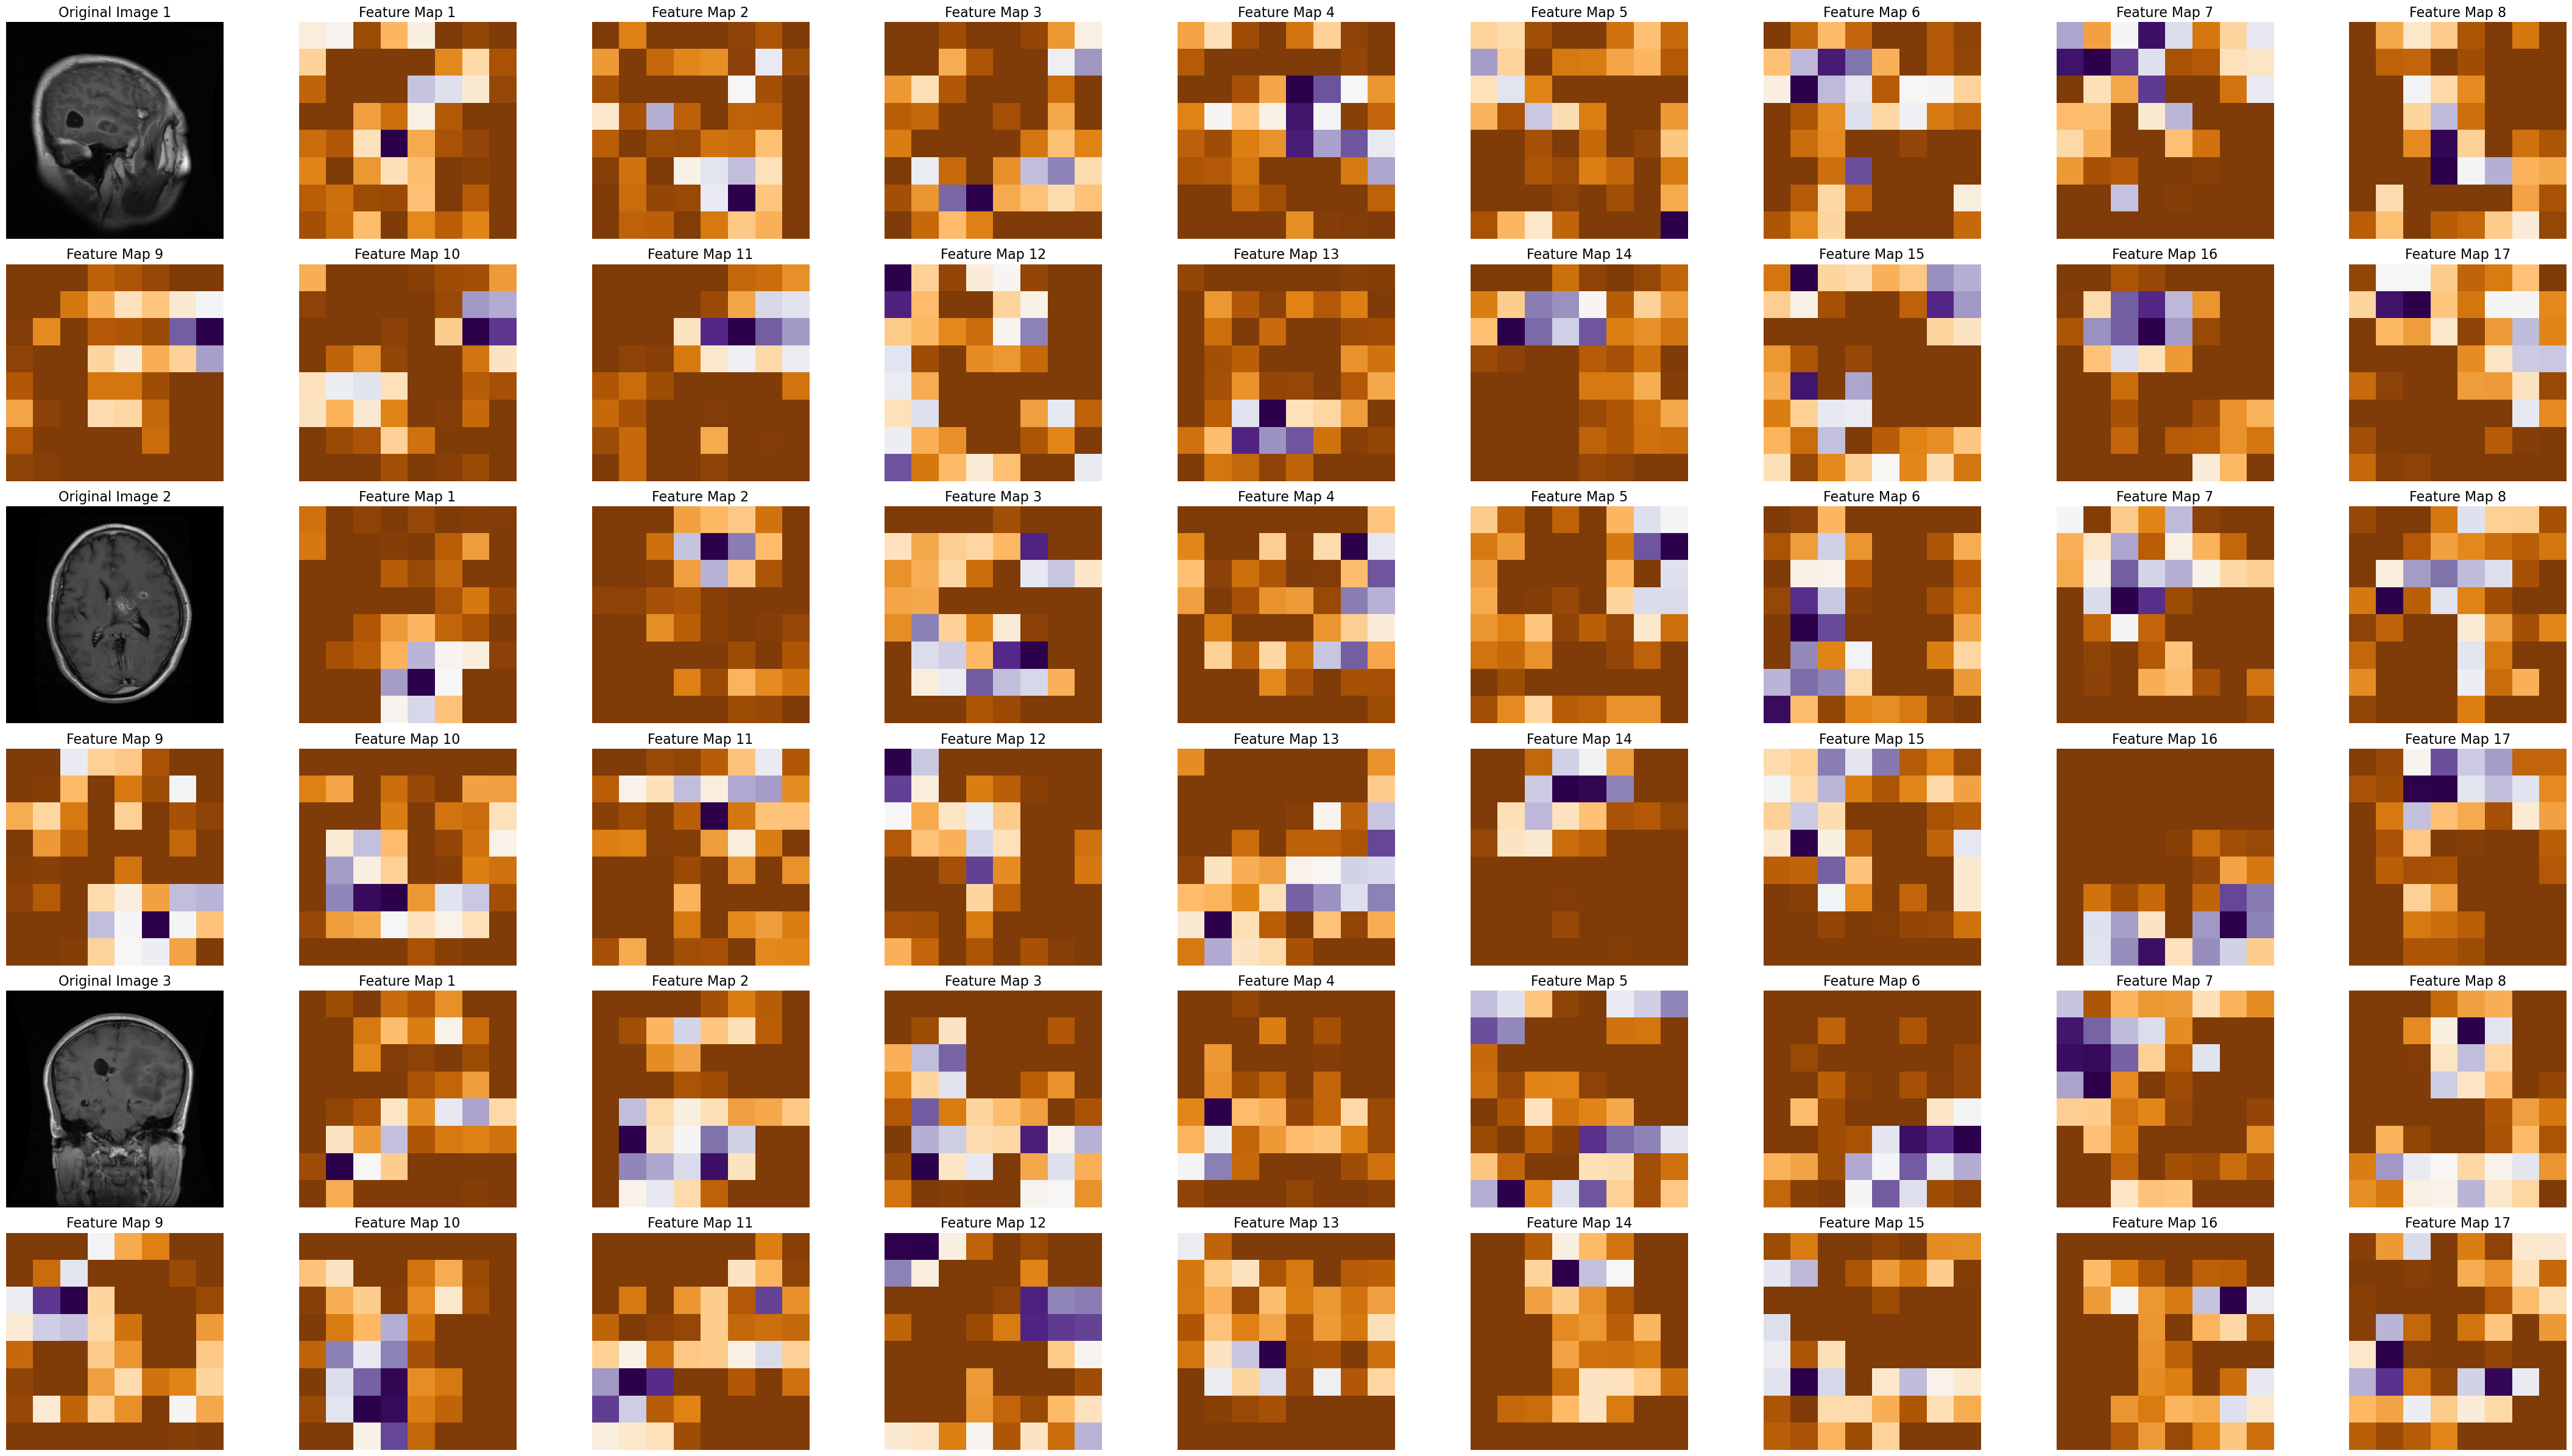

In [53]:
# ChatGPT assisted in the generation of this feature map code, with adjustments made
# for legible static typing and comments made to showcase understanding. 

# Extract the model up to the desired layer
intermediate_layer_model: torch.nn.Sequential = (
    torch.nn.Sequential(*list(resnet50.children())[:8]) # Including up to layer3
)
intermediate_layer_model.to(device)

# Get the first test image and add a batch dimension
test_image_tensor: Tensor = test_tensors[0].unsqueeze(0).to(device)

# Ensure model does not get modified, and showcase output
with torch.no_grad():
    intermediate_output = intermediate_layer_model(test_image_tensor)

# Number of feature maps to visualize
NUM_FEATURE_MAPS: int = 17

# Output shape to understand inner-workings
INTERMEDIATE_OUTPUT_SHAPE: Tuple[int,int,int,int] = tuple(intermediate_output.shape)
print(f"Intermediate output shape is of shape {INTERMEDIATE_OUTPUT_SHAPE}.")

# print(f"The intermediate ")

plt.figure(figsize=(44, 24))  # Adjust the figure size for clarity

# Loop for three images
for i in range(3):
    # Get the test image and add a batch dimension
    test_image_tensor: Tensor = test_tensors[i].unsqueeze(0).to(device)

    # Ensure model does not get modified, and showcase output
    with torch.no_grad():
        intermediate_output = intermediate_layer_model(test_image_tensor)
    
    # Plot the original image first
    plt.subplot(6, 9, 1 + i*18)  # Adjust subplot grid to include one more for the original image and position it correctly
    original_img = test_image_tensor[0].cpu().numpy().transpose(1, 2, 0)
    plt.imshow(original_img, cmap='gray' if original_img.shape[2] == 1 else None)  # Display as grayscale if it's a single-channel image
    plt.axis('off')
    plt.title(f'Original Image {i+1}', fontdict={'size': 16})  # Title only for the first row to avoid repetition
    
    # Plot the feature maps
    for j in range(NUM_FEATURE_MAPS):
        plt.subplot(6, 9, j + 2 + i*18)  # Adjust indices to leave space for the original image and position it correctly for each image row
        plt.imshow(
            intermediate_output[0, j].cpu().detach().numpy(),  # Showcases feature maps for each index shown
            cmap='PuOr',  # Use 'PuOr' colormap for better visualization
        )  
        plt.axis('off')
        plt.title(f'Feature Map {j+1}', fontdict={'size': 16})  # Title only for the first row to avoid repetition

plt.tight_layout()
plt.show()

In the plot above, we output the contrasting values of numbers stored in 17 of the 2048 feature maps for 3 MRI images. 

We can't visually interpret exactly what is going on from the feature extraction process of a Convolutional Neural Network like ResNet, but the generated feature maps offer a look into the network's perception of the input image at certain stages of traversing through a deep neural network. Each feature map represents the result of dot products and/or applications of activation functions from different filters within the convolutional layers, highlighting various aspects and features of the input. Some maps might amplify edges, while others may focus on textures or more abstract patterns. In the feature maps, we can see how the pooling operations, for example, reduce dimensionality and compress the high dimensional images into a heatmap of size $8 \times 8$, reducing the noise in the overall image and capturing more complex features that can shed light on certain features. (ChatGPT assisted in writing this paragraph, but we heavily modified it)

In the realm of brain MRI imaging, understanding these feature maps is especially crucial. They underscore the network's capacity to identify and respond to subtle nuances in the images—nuances that could mean the difference between detecting a potential tumor in an MRI scan and overlooking it. As data from an image progresses through ResNet's layers, these features become more refined and abstract, preparing the network to make its final classifications or predictions with a rich context. Even though the intricate details of these feature maps are not susceptible to human interpretation, for the neural network, they showcase informed and accurate decision-making.

## **4: Exceptional Work**